# Занятие 8. Ансамблевое обучение и случайные леса
Предположим, вы задаёте сложный вопрос тысячам случайных людей и затем агрегируете их ответы. Во многих случаях вы обнаружите, что такой агрегированный ответ оказывается лучше, чем ответ эксперта. Это называется <i>коллективным разумом, или мудростью толпы</i>. Аналогично если вы агрегируете прогнозы группы прогнозаторов (таких как классификаторы или регрессоры), то часто будете получать лучшие прогнозы, чем прогноз от наилучшего индивидуальноо прогнозатора. Группа прогнозаторов называется <b>ансамблем</b>; соответственно приём носит название <b>ансамблевое обучение</b>, а алгоритм ансамблевого обучения именуется <b>ансамблевым методом</b>.

В качестве примера ансамблевого метода вы можете обучать группу классификаторов на основе деревьев принятия решений, задействовав для каждого отличающийся случайный набор поднабор из обучающего набора. Для вырабатывания прогнозов вы лишь получаете прогнозы всех индвидуальных деревьев и прогнозируете класс, который стал обладателем большинства голосов. Такой ансамбль деревьев принятия решений называется <b>случайным лесом</b> и, несмотря на простоту, является одним из самых мощных алгоритмов МО, доступных на сегодняшний день.

Как правило, ансамблевые методы используются ближе к концу проекта, когда несколько хороших прогнозаторов уже построены, чтобы объединить их в ещё лучший прогнозатор. Тем не менее, выигрышные решения в состязаниях по МО зачастую включают в себя некоторое количество ансамблевых методов.

В этом занятии мы обсудим наиболее популярные ансамблевые методы, в том числе <i>бэггинг</i> (bagging), <i>бустинг</i> (boosting) и <i>стекинг</i> (stacking). Мы также исследуем случайные леса.

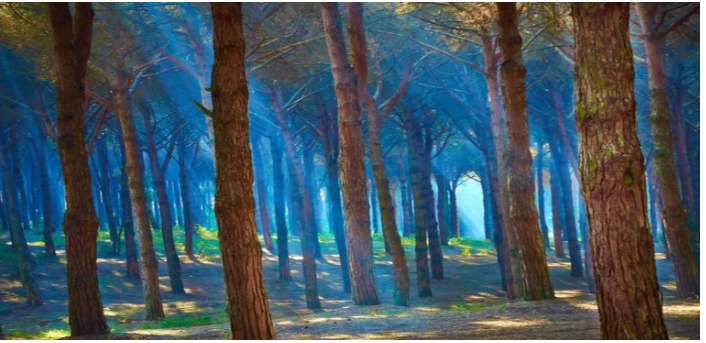

## Классификаторы с голосованием
Допустим, вы обучили несколько классификаторов, и каждый из них обеспечивает правильность около 80%. У вас может быть классификатор на основе логистической регрессии, классификатор SVM, классификатор на базе случайного леса, классификатор методом k ближайших соседей и, вероятно, ряд других.

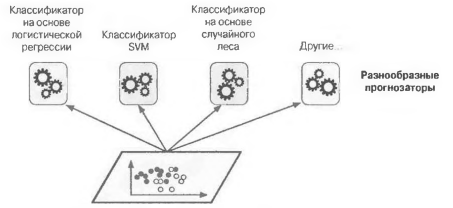

Очень простой способ создания ещё лучшего классификатора предусматривает агрегирование прогнозов всех классификаторов и прогнозирование класса, который получает наибольшее число голосов. Такой мажоритарный классификатор называется классификатором с <i>жестким голосованием</i>.

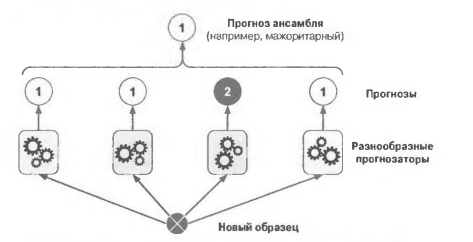

Отчасти удивительно, но данный классификатор с голосованием часто достигает большей правильности, чем наилучший классификатор в ансамбле. На самом деле, даже если каждый классификатор является <i>слабым учеником</i>, т.е. он лишь немногим лучше случайного угадывания, то ансамбль по-прежнему может быть <i>сильным учеником</i>, обеспечивая высокую правильность, при условии, что есть достаточное количество слабых учеников и они достаточно разнообразны.

Как подобное возможно? Пролить свет на эту тайну поможет следующая аналогия. Предположим, у вас слегка несимметричная монета, которая имеет 51%-й шанс упасть на лицевую сторону (орел) и 49%-й шанс $-$ на обратную сторону (решка). Если вы бросите её 1 000 раз, то в целом получите примерно 510 орлов и 490 решек, и таким образом большинство орлов. Обратившись к математике, вы обнаружите, что вероятность получения большинства орлов после 1 000 бросков близка к 75%. Чем больше вы будете бросать монету, тем выше эта вероятность (скажем, при 10 000 бросков вероятность преодолевает планку 97%). Код ниже демонстрирует этот пример.

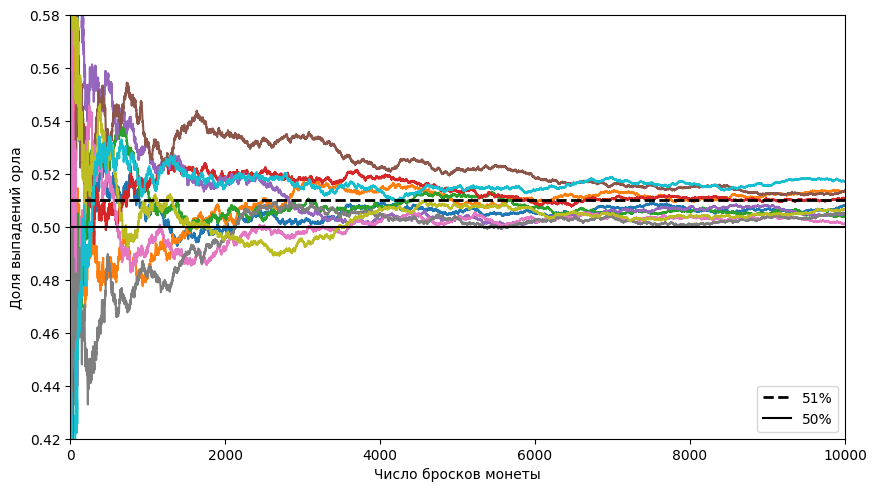

In [1]:
import numpy as np
import matplotlib.pyplot as plt

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(10,5.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Число бросков монеты")
plt.ylabel("Доля выпадений орла")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

Это связано с <i>законом больших чисел</i>: по мере продолжения бросания монеты доля выпадения орлов становится все ближе и ближе к вероятности орлов (51%). 

Аналогичным образом допустим, что вы строите ансамбль, содержащий 1 000 классификаторов, которые по отдельности корректны только 51% времени (едва ли лучше случайного угадывания). Если вы проогнозируете мажоритарный класс, то можете надеяться на правильность до 75%! Однако это справедливо, только если все классификаторы полностью независимы, допуская несвязанные ошибки, что явно не наша ситуация, т.к. они обучались на одних и тех же данных. Скорее всего, классификаторы будут допускать ошибки одинаковых типов, а потому во многих случаях большинство голосов отдаётся некорректному классу, снижая правильность ансамбля.

Ансамблевые методы работают лучше, когда прогнозаторы являются как можно более назависимыми друг от друга. Один из способов получить несходные классификаторы заключается в том, чтобы обучать их с применением разных алгоритмов. Это увеличит шансы, что они будут допускать ошибки сильно различающихся типов, способствуя повышению правильности ансамбля.

Следующий код создаёт и обучает с помощью Scikit-Learn классификатор с голосованием, состоящий из несходных классификаторов (в качестве обучающего набора используется набор данных moons).

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# создание и разделение данных
X, y = make_moons(n_samples=500, noise=.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# инициализация классификаторов
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# объединение всех в один ансамбль
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),
                ('svc', svm_clf)], voting='hard'
)

# обучение ансамбля
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
# вычислить правильность на испытательном наборе
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred)}")

LogisticRegression: 0.864
RandomForestClassifier: 0.904
SVC: 0.896
VotingClassifier: 0.912


Вот так! Классификатор с голосованием слегка превосходит все индивидуальные классификаторы.

Если все классификаторы в состояни оценивать вероятности классов (т.е. все они имеют метод predict_proba()), тогда вы можете сообщить Scikit-Learn о необходимости прогнозирования класса с наивысшей вероятностью класса, усреднённой по всем индивидуальным классификаторам. Это называется <i>мягким голосованием</i>. Оно часто добивается более высокой эффективности, чем жесткое голосование, потому что придаёт больший вес голосам с высоким доверием. Всё, что вам потребуется $-$ поменять voting='hard' на voting='soft' и удостовериться в способности классификаторов оценивать вероятности классов. По умолчанию такой вариант в классе SVC не принимается, поэтому вам понадобится установить его гиперпараметр probability в True (что заставит класс SVC применять перекрестную проверку, замедляя обучение, и добавит метод predict_proba()). Если вы модифицируете предыдущий код для использования мягкого голосования, то обнаружите, что классификатор с глосованием добавивается правильности свыше 91.2%!

In [4]:
# инициализация классификаторов
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

# объединение всех в один ансамбль
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),
                ('svc', svm_clf)], voting='soft'
)

# обучение ансамбля с мягким голосованием
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred)}")

LogisticRegression: 0.864
RandomForestClassifier: 0.904
SVC: 0.896
VotingClassifier: 0.904


## Бэггинг и вставка


Как только что обсуждалось, один из способов получения наборов несходных классификаторов заключается в применении очень разных алгоритмов обучения. Другой подход предусматривает использование для каждого прогнозатора одного и того же алгоритма обучения, но обучение прогнозатора на разных случайных поднаборах обучающего набора. Когда выборка осуществляется с заменой, такой метод называется <b>бэггингом</b> -- сокращение от bootstrap aggregating. В статистике повторная выборка с заменой называется бустраппингом.

Когда выборка выполняется без замены, такой метод называется <b>вставкой или вклеиванием</b>.

Другими словами, бэггинг и вставка позволяют производить выборку обучающих образцов по нескольку раз множеством прогнозаторов, но только бэггинг разрешает осуществлять выборку обучающих образцов по нескольку раз одним и тем же прогнозатором.

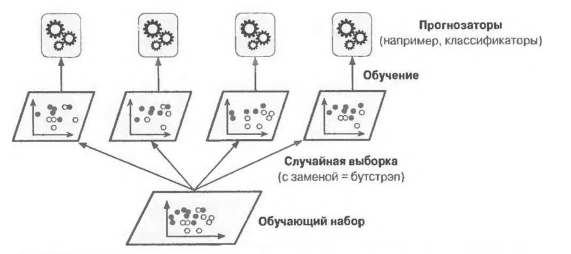

После того, как все прогнозаторы обучены, ансамбль может вырабатывать прогноз для нового образца, просто агрегируя прогнозы всех прогнозаторов. Функция агрегирования обычно представляет собой <i>статистическую моду</i> для классификации или среднее для регрессии. Каждый индивидуальный прогнозатор имеет более высокое смещение, нежели если бы он обучался на исходном обучающем наборе, но агрегирование сокращает и смещение, и дисперсию. Обычно совокупный результат состоит в том, что ансамбль имеет похожее смещение, но меньшую дисперсию, чем одиночный прогнозатор, обученный на исходном обучающем наборе.

На рисунке выше можно заметить, что все прогнозаторы могут обучаться параллельно, через разные процессорные ядра или даже разные серверы. Аналогично параллельно могут вырабатываться и пронозы. Это одна из причин, по котороой бэггинг и вставка являются настолько популярными методами: они очень хорошо масштабируются.

## Бэггинг и вставка в Scikit-Learn

Библиотека Scikit-Learn предлагает простой API-интерфейс в виде класса BaggingClassifier для бэггинга и вставки (или BaggingRegressor для регрессии). Показанный ниже код обучает ансамбль из 500 классификаторов на основе деревьев принятия решений, каждый из которых обучается на 100 обучающих образцах, случайно выбранных из обучающего набора с заменой (пример бэггинга, но если вы хотите применять вставку, тогда просто установите bootstrap=False). Параметр n_jobs сообщает Scikit-Learn количество процессорных ядер для использования при обучении и прогнозировании (-1 указывает на необходимость участия всех доступных ядер):

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Класс BaggingClassifier автоматически выполянет вместо жесткого голосования мягкое голосование, если базовый классификатор может оценивать вероятности классов (т.е. если он имеет метод predict_proba()), как обстоит дело с классификаторами на основе деревьев принятия решений.

Бутстрэппинг привносит чуть болше несходства в поднаборы, на которых обучается каждый прогнозатор, и потому бэггинг в итоге дает слегка более высокое смещение, чем вставка, но дополнительное несходство также означает, что прогнозаторы будут менее зависимыми друг от друга, сокращая дисперсию ансамбля. В целом бэггинг часто приводит к лучшим моделям, что и является причиной, по которой ему обычно отдают предпочтение. Тем не менее, имея свободное время и выычислительную мощность, вы можете применить перекрёстную проверку для оценки бэггинга и вставки и выбрать подход, который работает лучше.

## Оценка на неиспользуемых образцах
При бэггинге некоторые образцы могут быть выбраны несколько раз для любого заданного прогнозатора, тогда как другие могут не выбираться вообще. По умолчанию класс BaggingClassifier производит выборку m обучающих образцов с заменой (Bootstrap=True), где m -- размер обучающего набора. Это означает, что для каждого прогнозатора будет выбираться в среднем только около 63% обучающих образцов. Оставшиеся 37% обучающихся образцов, которые не выбираются, называются <i>неиспользуемыми</i> (out-of-bag $-$ oob) образцами. Обратите внимание, что такие 37% образцов не одинаковы для всех прогнозаторов.

Посколько прогнозатор никогда не видит образцы oob во время обучения, его можно оценивать на образцах oob без необходимости в наличии отдельного проверочного набора. Вы можете оценивать сам ансамбль, усредняя оценки oob каждого прогнозатора.

При создании экземпляра BaggingClassifier в Scikit-Learn можно установить oob_score=True, чтобы запросить автоматическую оценку oob после обучения. Приём демонстрируется в следующем коде. Результирующая сумма оценки доступна через переменную oob_score_:

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8906666666666667

Согласно проведённой оценке oob классификатор BaggingClassifier, скорее всего, достигнет правильности 89.6% на испытательном наборе. Проверим:

In [7]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

Достаточно близко.

## Методы случайных участков и случайных подпространств
Класс BaggingClassifier также поддерживает выборку признаков. Выборка управляется двумя гиперпараметрами: max_features и bootstrap_features. Они работают в таком же духе, как max_samples и bootstrap, но предназначены для выборки признаков, а не выборки образцов. Таким образом, каждый прогнозатор будет обучаться на случайном поднаборе входных признаков.

Методика особенно полезна, когда вы имеете дело с исходными данными высокой размерности (такими как изображения). Выборка сразу обучающих образцов и признаков называется методом <i>случайных участков</i>. Сбережение всех обучающих образцов (за счёт установки bootstrap=False и max_samples=1.0), но проведение выборки признаков (путем установки bootstrap_features=True и/или max_features в значение меньше 1.0) называется методом <i>случайных подпространств</i>. Выборка признаков обеспечивает даже большее несходство прогнозаторов, обменивая чуть более высокое смещение на низкую дисперсию.

## Случайные леса
Ранее уже упоминалось, что <i>случайный лес</i> $-$ это ансамбль деревьев принятия решений, которые обычно построены посредством метода бэггинга (либо иногда вставки), как правило, с параметром max_samples, установленным в размер обучающего набора. Вместо построения экземпляра BaggingClassifier и его передачи экземпляру DecisionTreeClassifier вы можете применить класс RandomForestClassifier, который является более удобным и оптимизированным для деревьев принятия решений. Показанный ниже код использует все доступные процессорные ядра для обучения классификатора на основе случайного леса с 500 деревьями (каждое ограничено максимум 16 узлами):

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

С несколькими исключениями класс RandomForestClassifier имеет все гиперпараметры класса DecisionTreeClassifier (для управления ростом деревьев) плюс все гиперпараметры класса BaggingClassifier для управления самим ансамблем.

Алгоритм случайного леса вводит добавочную случайность, когда выращивает деревья; вместо поиска лучшего из лучших признаков при расщеплении узла он ищет наилучший признак в случайном поднаборе признаков. В результате получается более значительное несходство деревьев, которое обменивает более высокое смещение на низкую дисперсию, как правило, выдавая в целом лучшую модель.

### Особо случайные деревья
При выращивании дерева в случайном лесе для каждого узла, подлежащего расщеплению, рассматривается только случайный поднабор признаков (как говорилось ранее). Можно сделать деревья ещё более случайными за счёт применения случайных порогов для каждого признака вместо поиска наилучших возможных порогов (подобно тому, как поступают обыкновенные деревья решений). Лес с такими чрезвычайно случайными деревьями называется ансамблем <i>особо случайных деревьев</i>. И снова в такой методике более высокое смещение обменивается на низкую дисперсию. Кроме того, особо случайные деревья обучаются намного быстрее, чем обыкновенные случайные леса, поскольку нахождение наилучшего возможного порога для каждого признака в узле является одной из самых затратных в плане времени задач по выращиванию дерева.

Вы можете создать классификатор на основе особо случайных деревьев, используя класс ExtraTreesClassifier из Scikit-Learn. Его API-интерфейс идентичен API-интерфейсу класса RandomForestClassifier.

### Значимость признаков
Ещё одно замечательное свойство случайных лесов заключается в том, что они облегчают измерение относительной значимости каждого признака. Библиотека Scikit-Learn измеряет значимость признака путем выяснения, насколько узлы дерева, применяющие этот признак, снижают загрязненность в среднем (по всем деревьям в лесе). Выражаясь точнее, значимость признака представляет собой взвешенное среднее, где вес каждого узла равен количеству обучающих образцов, которые с ним ассоциировались.

Данный показатель подсчитывается в Scikit-Learn автоматически для каждого признака после обучения, а результаты масштабируются так, чо сумма всех значимостей равна 1. Вы можете обратиться к итоговому признаку с использованием переменной feature_importances_. Например, следующий код обучает классификатор случайного леса на наборе данных MNIST и выдаёт значимость каждого признака (в данном случае это пиксели, чем ярче пиксель, тем он значимее).

In [9]:
import warnings
warnings.filterwarnings('ignore')
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=500, random_state=42)

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

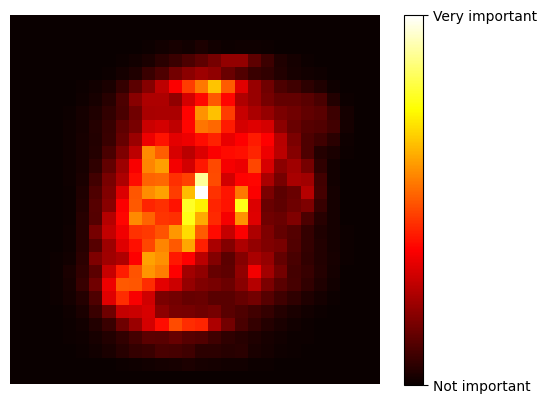

In [11]:
import matplotlib as mpl
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show();

Случайные леса очень удобны для быстрого понимания того, какие признаки действительно имеют значение, в особенности, если вам необходимо осуществлять выбор признаков.

## Бустинг
<i>Бустинг</i> (первоначально называемый <i>усилением гипотезы</i>) относится к любому ансамблевому методу, который способен комбинировать несколько слабых учеников в одного сильного ученика. Основная идея большинства методов бустинга предусматривает последовательное обучение прогнозаторов, причем каждый из них старается исправить своего предшественника. Доступно много методов бустинга, но безоговорочно самыми популярными являются AdaBoost $-$ сокращение от Adaptive Boosting (адаптивный бустинг) и градиентный бустинг (Gradient Boosting). Начнем с AdaBoost.

### AdaBoost
Один из способов, которым новый прогнозатор может исправлять своего предшественника, заключается в том, что он уделяет чуть больше внимания обучающим образцам, на которых у предшественника было недообучение. В результате новые прогнозаторы все больше и больше концентрируются на трудных случаях. Именно такой прием применяет метод AdaBoost.

Например, при обучении классификатора AdaBoost алгоритм сначала обучает базовый классификатор (такой как дерево решений) и использует его для выработки прогнозов на обучающем наборе. Затем алгоритм увеличивает относительный вес некорректно классифицированных обучающих образцов. Далее он обучает второй классификатор с применением обновлённых весов, снова вырабатывает прогнозы на обучающем наборе, обновляет веса и так далее. 

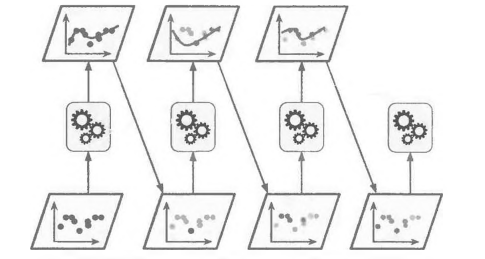

Код и иллюстрации ниже представляют границы решений пяти последовательных прогнозаторов на наборе данных moons (в рассматриваемом примере каждый прогнозатор является сильно регуляризированным SVM с ядром RBF, но это только в целях иллюстрации. Методы опорных векторов в целом не являются хорошими прогнозаторами для AdaBoost, потому что они медленные и склонны к нестабильной работе с AdaBoost.

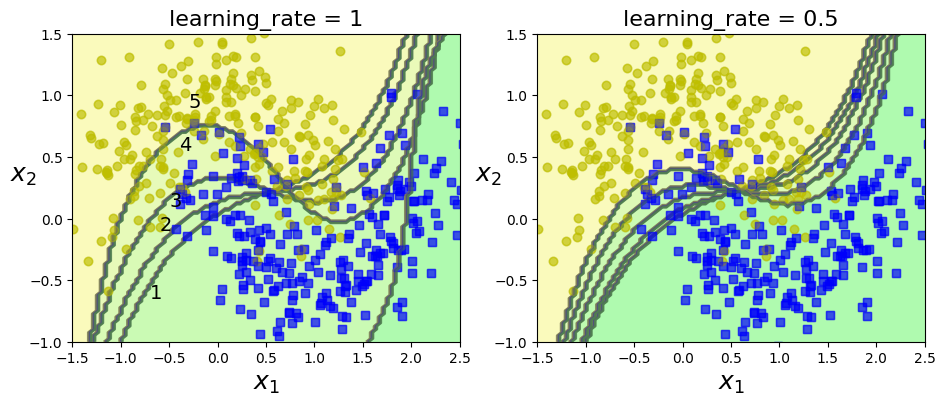

In [12]:
m = len(X_train)


from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

Первый классификатор воспринимает многие образцы неправильно, так что их веса повышаются. Вследствие этого второй классификатор справляется с такими образцами лучше и т.д. На графике справа представлена та же самая последовательность прогнозаторов, но скорость обучения уменьшена вдвое (т.е. на каждой итерации веса некорректно классифицированных образцов поднимаются максимум наполовину). 

Как видите, такой прием последовательного обучения имеет некоторые сходные черты с градиентным спуском, но вместо подстройки параметров одиночного прогнозатора для сведения к минимуму функции издержек AdaBoost добавляет прогнозаторы в ансамбль, постепенно делая его лучше.

После того как все прогнозаторы обучены, ансамбль вырабатывает прогнозы очень похоже на бэггинг или вставку за исключением того, что прогнозаторы имеют разные веса в зависимости от их общей правильности на взвешенном обучающем наборе.

У методики последовательного обучения есть один важный недостаток: она не допускает распараллеливания (или только частично), поскольку каждый прогнозатор можно обучать лишь после того, как был обучен и оценен предыдущий прогнозатор. 
В результате такая методика не масштабируется настолько хорошо, как бэггинг или вставка.

Библиотека Scikit-Learn использует многоклассовую версию алгоритма AdaBoost, называемую SAMME, что означает Stagewise Additive Modeling using a Multiclass Exponential loss function (ступенчатое аддитивное моделирование с применением многоклассовой экспоненциальной функции потерь). Когда классов только два, алгоритм SAMME эквивалентен алгоритму AdaBoost. Кроме того, если прогнозаторы способны оценивать вероятности классов (имеют метод predict_proba()), то Scikit-Learn может использовать вариант SAMME под названием SAMME.R (R означает real $-$ вещественный), который полагается на вероятности классов, а не на прогнозы, и в целом выполняется лучше.

Приведенный ниже код обучает классификатор AdaBoost, основанный на 200 пеньках решений (Decision Stump), с применением класса AdaBoostClassifier из Scikit-Learn (как вы могли догадаться, имеется также класс AdaBoostRegressor). Пенек решения представляет собой дерево принятия решений с max_depth=l — иными словами, дерево, состоящее из одного узла решения и двух листовых узлов. Это стандартный базовый оценщик для класса AdaBoostClassifier.

Если ваш ансамбль AdaBoost переобучается обучающим набором, тогда можете сократить количество оценщиков или более строго регуляризировать базовый оценщик.

### Градиентный бустинг
Другим популярным вариантом бустинга является <i>градиентный бустинг</i>. Подобно AdaBoost градиентный бустинг работает, последовательно добавляя в ансамбль прогнозаторы, каждый из которых корректирует своего предшественника. Тем не менее, вместо подстройки весов образцов на каждой итерации, как делает AdaBoost, этот метод старается подогнать новый прогнозатор к <b>остаточным ошибкам</b>, допущенным предыдущим прогнозатором. 

Рассмотрим простой пример регрессии, использующий деревья принятия решений в качестве базовых прогнозаторов (разумеется, градиентный бустинг прекрасно работает также и с задачами регрессии). Это называется <i>градиентным бустингом на основе деревьев</i> или <i>деревьями регрессии с градиентным бустингом</i>. Первым делом подгоним регрессор DecisionTreeRegressor к обучающему набору (например, зашумлённому квадратичному обучающему набору).

In [13]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(2023)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Далее мы обучим второй регрессор на остаточных ошибках, допущенных первым регрессором.

In [14]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

Затем обучим третий регрессор на остаточных ошибках, допущенных вторым прогнозатором:

In [15]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

Теперь мы располагаем ансамблем, содержащим 3 дерева. Он может вырабатывать прогнозы на новом образце, просто суммируя прогнозы всех трех деревьев:

In [16]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.58005765])

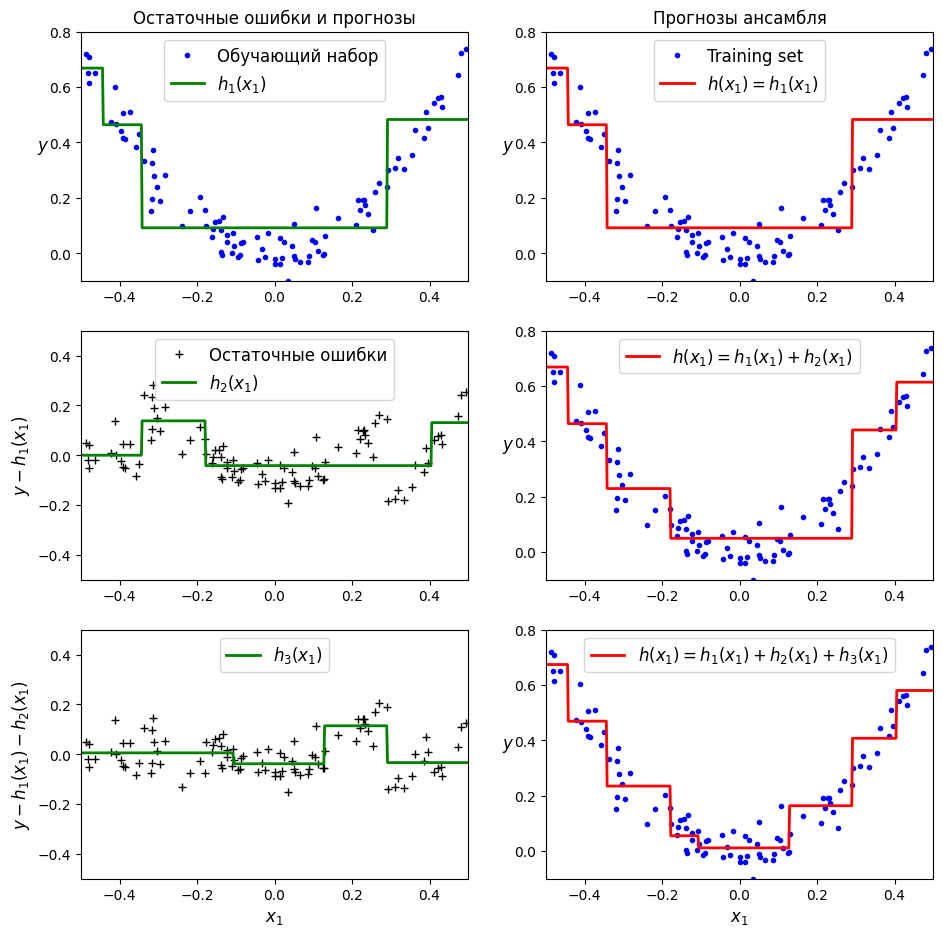

In [17]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=12)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Обучающий набор")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Остаточные ошибки и прогнозы", fontsize=12)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Прогнозы ансамбля", fontsize=12)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Остаточные ошибки")
plt.ylabel("$y - h_1(x_1)$", fontsize=12)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=12, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=12)
plt.xlabel("$x_1$", fontsize=12)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$y$", fontsize=12, rotation=0)

plt.show()

Код выше можно заменить на простой библиотечный класс GradientBoostingRegressor из Scikit-Learn, но он крайне не оптимизирован. Вместо него лучше использовать реализацию из другой библиотеки Python под названием XGBoost, которое означает Extreme Gradient Boosting (экстремальный градиентный бустинг). Изначально пакет был разработан Тяньцзи Ченом в сообществе распределённого (глубокого) машинного обучения и задуман стать исключительно быстрым, масштабируемым и переносимым. Фактически XGBoost является важным компонентом победивших решений в состязаниях по МО.

In [18]:
!pip install -q xgboost
import xgboost
xgb_reg = xgboost.XGBRegressor() 
xgb_reg.fit(X, y) 
у_pred = xgb_reg.predict(X_new)
y_pred

DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


array([0.58005765])

## Стекинг
Последний ансамблевый метод называется <i>стекингом</i> (stacking $-$ сокращение для "stacked generation", "стековое обобщение"). Он основан на простой идее: вместо того, чтобы использовать тривиальные функции (такие как с жестким голосованием) для агрегирования прогнозов всех прогнозаторов в ансамбле, почему бы ни научить какую-то модель делать это агреирование? 
На рисунке ниже демонстрируется ансамбль подобного рода, выполняющий задачу регрессии на новом образце. Кажждый из трех нижних прогнозаторов прогнозирует отличающееся значение, после чего финальный прогнозатор (называемый <i>смесителем</i> или <i>мета-учеником</i>) получает на входе такие прогнозы и вырабатывает окончательный прогноз.

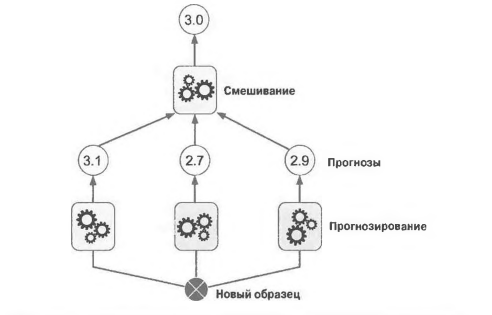

Распространённый подход к обучению смесителя предполагает использование <i>удерживаемого (hold-on) набора</i>. Давайте посмотрим, как это работает. Для начала обучающий набор расщепляется на два поднабора. Первый поднабор применяется для обучения прогнозаторов на первом уровне.

Затем прогнозаторы первого уровня используются для вырабатывания прогнозов на втором (удержанном) наборе. Тем самым гарантируется, что прогнозы являются "чистыми", так как прогнозаторы ни разу не видели данных образцов во время обучения. 

Теперь для каждого образца в удерживаемом наборе есть три спрогнозированных значения. Мы можем создать новый обучающий набор, применяя эти спрогнозированные значения как входные признаки (что делает новый 
обучающий набор трехмерным) и сохраняя целевые значения. Смеситель обучается на новом обучающем наборе, а потому учится прогнозировать целевое значение, имея прогнозы первого уровня.

На самом деле подобным образом можно обучить несколько разных смесителей (например, смеситель, использующий линейную регрессию, и еще один смеситель, применяющий регрессию на основе случайного леса), чтобы получить целый уровень смесителей. Трюк предусматривает расщепление обучающего набора на три поднабора. Первый поднабор используется для обучения первого уровня. Второй поднабор предназначен для создания обучающего набора, который применяется при обучении второго уровня (и использует прогнозы, выработанные прогнозаторами первого уровня). Третий поднабор позволяет создать обучающий набор для обучения третьего уровня (и применяет прогнозы, сделанные прогнозаторами второго уровня). После этого мы можем вырабатывать прогноз для нового образца, последовательно проходя по всем уровням.

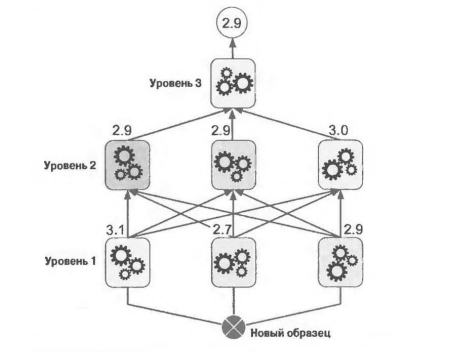

К сожалению, Scikit-Learn не поддерживает стекинг напрямую, но развернуть собственную реализацию не слишком сложно (см. упражнения ниже).

## Упражнения

1. Загрузите данные MNIST и расщепите их на три набора: обучающий, проверочный и испытательный (например, в соотношении 5:1:1). Затем обучите разные классификаторы, например, классификатор на основе случайного леса, классификатор на базе особо случайных деревьев и классификатор SVM. Далее попытайтесь объединить их в ансамбль, который превосходит каждый индивидуальный классификатор в нём на проверочном наборе, используя классификатор с мягким или жёстким голосованием. После получения ансамбля опробуйте его на испытательном наборе. Насколько лучше он выполняется в сравнении с индивидуальными классификаторами? 

2. Запустите индивидуальные классификаторы из предыдущего упражнения, чтобы выработать прогнозы на проверочном наборе, и создайте новый обучающий набор с результирующими прогнозами: каждый обучающий образец представляет собой вектор, содержащий набор прогнозов от всех классификаторов для изображения, и целью является класс изображения. Обучите классификатор на основе этого нового обучающего набора. Примите поздравления: вы только что обучили смеситель, который вместе с классификаторами образует ансамбль со стекингом! Теперь оцените ансамбль на испытательном наборе. Для каждого изображения в испытательном наборе выработайте прогнозы с помощью всех имеющихся классификаторов, после чего передайте эти прогнозы смесителю, чтобы получить прогнозы ансамбля. Как результаты соотносятся с результатами обученного ранее классификатора с голосованием?